# Example: Properties

#### Imports

In [1]:
import numpy as np
import torch
import time
from pathlib import Path
import gc

import dxtb

import logging

logging.getLogger().setLevel(logging.ERROR)

In [2]:
def _tensors_from_gc() -> list:
    return [obj for obj in gc.get_objects() if isinstance(obj, torch.Tensor)]


def _get_tensor_memory(
    return_number_tensors: bool = False,
) -> float | tuple[float, int]:
    """
    Obtain the total memory occupied by torch.Tensor in the garbage collector.

    Returns
    -------
    tuple[float, int]
        Memory in MiB and number of tensors.
    """

    # obtaining all the tensor objects from the garbage collector
    tensor_objs = _tensors_from_gc()

    # iterate each tensor objects uniquely and calculate the total storage
    visited_data = set()
    total_mem = 0.0
    for tensor in tensor_objs:
        if tensor.is_sparse:
            continue

        # check if it has been visited
        storage = tensor.storage()
        data_ptr = storage.data_ptr()  # type: ignore
        if data_ptr in visited_data:
            continue
        visited_data.add(data_ptr)

        # calculate the storage occupied
        numel = storage.size()
        elmt_size = storage.element_size()
        mem = numel * elmt_size / (1024 * 1024)  # in MiB

        total_mem += mem

    if return_number_tensors is True:
        return total_mem, len(tensor_objs)
    return total_mem

#### dxtb calculation

In [3]:
f = Path(globals()['_dh'][0]) / "molecules" / "nylon.xyz"
atoms, xyz = dxtb.io.read_structure_from_file(f)

In [4]:
device = torch.device("cpu")
dd: dxtb._types.DD = {"device": device, "dtype": torch.double}

numbers = torch.tensor(atoms, device=device)
positions = torch.tensor(xyz, **dd)
GFN1_XTB = dxtb.GFN1_XTB

ihelp = dxtb.IndexHelper.from_numbers(
    numbers, dxtb.param.get_elem_angular(GFN1_XTB.element)
)

### Autograd utils

In [5]:
repeats = 10

times = {}


def nth_derivative(f, wrt, n=1):
    if n == 0:
        return

    create_graph = False if n == 1 else True

    for _ in range(n):
        (grads,) = torch.autograd.grad(f, wrt, create_graph=create_graph)
        f = grads.sum()

    return grads  # type: ignore


def print_average(times):
    print()
    if repeats > 1:
        avg_time = sum(times) / len(times)
        print(f"Average ({repeats}): {avg_time:2.4f} sec")
        return avg_time


def time_operation(operation, pos, n):
    times = []
    for _ in range(repeats):
        gc.collect()
        _pos = pos.detach().clone().requires_grad_(True)

        ts = time.perf_counter()

        s = operation(_pos).sum()  # Execute the operation passed as an argument

        size, num = _get_tensor_memory(return_number_tensors=True)
        ds = nth_derivative(s, _pos, n=n)
        size0, num0 = _get_tensor_memory(return_number_tensors=True)

        te = time.perf_counter()
        times.append(te - ts)

        print(f"{size - size0:.16f} MiB of {num-num0:d} addtional tensors")

        gc.collect()
        print(f"{te - ts:2.4f}", end=" ")

    avg_time = print_average(times)
    return avg_time

# Analytical

In [6]:
ihelp = dxtb.IndexHelper.from_numbers(
    numbers, dxtb.param.get_elem_angular(GFN1_XTB.element)
)

rep = dxtb.new_repulsion(numbers, GFN1_XTB)
assert rep is not None
cache = rep.get_cache(numbers, ihelp)

t1 = {}

### Energy

In [7]:
n = 0
t1[n] = time_operation(lambda pos: rep.get_energy(pos, cache), positions, n)

/opt/miniforge3/envs/dxtb/lib/python3.10/site-packages/torch/distributed/distributed_c10d.py:283: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  warnings.warn(
/tmp/ipykernel_2465530/1953877020.py:2: PydanticDeprecatedSince20: `pydantic.config.Extra` is deprecated, use literal values instead (e.g. `extra='allow'`). Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.0.3/migration/
  return [obj for obj in gc.get_objects() if isinstance(obj, torch.Tensor)]
/tmp/ipykernel_2465530/1953877020.py:28: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = tensor.storage()
/tmp/ipykernel_2465530/1953877020.py:29: UserWarning: TypedStora

0.0000000000000000 MiB of 0 addtional tensors
0.4793 0.0000000000000000 MiB of 0 addtional tensors
0.4485 0.0000000000000000 MiB of 0 addtional tensors
0.4279 0.0000000000000000 MiB of 0 addtional tensors
0.4087 0.0000000000000000 MiB of 0 addtional tensors
0.4391 0.0000000000000000 MiB of 0 addtional tensors
0.4093 0.0000000000000000 MiB of 0 addtional tensors
0.4021 0.0000000000000000 MiB of 0 addtional tensors
0.4158 0.0000000000000000 MiB of 0 addtional tensors
0.4371 0.0000000000000000 MiB of 0 addtional tensors
0.3956 
Average (10): 0.4263 sec


### 1st Derivative

In [8]:
n = 1
t1[n] = time_operation(lambda pos: rep.get_energy(pos, cache), positions, n)

/tmp/ipykernel_2465530/1953877020.py:2: PydanticDeprecatedSince20: `pydantic.config.Extra` is deprecated, use literal values instead (e.g. `extra='allow'`). Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.0.3/migration/
  return [obj for obj in gc.get_objects() if isinstance(obj, torch.Tensor)]
/tmp/ipykernel_2465530/1953877020.py:28: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = tensor.storage()
/tmp/ipykernel_2465530/1953877020.py:29: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.u

184.6383590698242188 MiB of 7 addtional tensors
0.7818 184.6838607788085938 MiB of 8 addtional tensors
0.7454 184.6838607788085938 MiB of 8 addtional tensors
0.7726 184.6838607788085938 MiB of 8 addtional tensors
0.7743 184.6838607788085938 MiB of 8 addtional tensors
0.7759 184.6838607788085938 MiB of 8 addtional tensors
0.7424 184.6838607788085938 MiB of 8 addtional tensors
0.7387 184.6838607788085938 MiB of 8 addtional tensors
0.8171 184.6838607788085938 MiB of 8 addtional tensors
0.8149 184.6838607788085938 MiB of 8 addtional tensors
0.8428 
Average (10): 0.7806 sec


### 2nd Derivative

In [9]:
n = 2
t1[n] = time_operation(lambda pos: rep.get_energy(pos, cache), positions, n)

/tmp/ipykernel_2465530/1953877020.py:2: PydanticDeprecatedSince20: `pydantic.config.Extra` is deprecated, use literal values instead (e.g. `extra='allow'`). Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.0.3/migration/
  return [obj for obj in gc.get_objects() if isinstance(obj, torch.Tensor)]
/tmp/ipykernel_2465530/1953877020.py:28: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = tensor.storage()
/tmp/ipykernel_2465530/1953877020.py:29: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.u

-150.8078384399414062 MiB of -8 addtional tensors
2.5622 184.7293624877929688 MiB of 9 addtional tensors
2.9171 184.7293624877929688 MiB of 9 addtional tensors
1.9115 184.7293624877929688 MiB of 9 addtional tensors
1.8588 184.7293624877929688 MiB of 9 addtional tensors
1.8503 184.7293624877929688 MiB of 9 addtional tensors
1.8566 184.7293624877929688 MiB of 9 addtional tensors
1.7930 184.7293624877929688 MiB of 9 addtional tensors
1.8299 184.7293624877929688 MiB of 9 addtional tensors
1.8423 184.7293624877929688 MiB of 9 addtional tensors
1.8242 
Average (10): 2.0246 sec


### 3rd Derivative

In [10]:
n = 3
t1[n] = time_operation(lambda pos: rep.get_energy(pos, cache), positions, n)

/tmp/ipykernel_2465530/1953877020.py:2: PydanticDeprecatedSince20: `pydantic.config.Extra` is deprecated, use literal values instead (e.g. `extra='allow'`). Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.0.3/migration/
  return [obj for obj in gc.get_objects() if isinstance(obj, torch.Tensor)]
/tmp/ipykernel_2465530/1953877020.py:28: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = tensor.storage()
/tmp/ipykernel_2465530/1953877020.py:29: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.u

-150.8078460693359375 MiB of -9 addtional tensors
4.7783 184.7293624877929688 MiB of 9 addtional tensors
6.2945 184.7293624877929688 MiB of 9 addtional tensors
4.1791 184.7293624877929688 MiB of 9 addtional tensors
4.0122 184.7293624877929688 MiB of 9 addtional tensors
4.1828 184.7293624877929688 MiB of 9 addtional tensors
4.0778 184.7293624877929688 MiB of 9 addtional tensors
4.1385 184.7293624877929688 MiB of 9 addtional tensors
3.9970 184.7293624877929688 MiB of 9 addtional tensors
4.0171 184.7293624877929688 MiB of 9 addtional tensors
4.0776 
Average (10): 4.3755 sec


### 4th Derivative

In [11]:
n = 4
# t1[n] = time_operation(lambda pos: rep.get_energy(pos, cache), positions, n)

# Full Autograd

In [12]:
ihelp = dxtb.IndexHelper.from_numbers(
    numbers, dxtb.param.get_elem_angular(GFN1_XTB.element)
)

rep = dxtb.new_repulsion(numbers, GFN1_XTB)
assert rep is not None
cache = rep.get_cache(numbers, ihelp)

def eval(pos, c):
    e = dxtb.classical.repulsion.repulsion_energy(
        pos, c.mask, c.arep, c.kexp, c.zeff
    )
    return 0.5 * torch.sum(e, dim=-1)

t2 = {}

### Energy

In [13]:
n = 0
t2[n] = time_operation(lambda pos: eval(pos, cache), positions, n)

/tmp/ipykernel_2465530/1953877020.py:2: PydanticDeprecatedSince20: `pydantic.config.Extra` is deprecated, use literal values instead (e.g. `extra='allow'`). Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.0.3/migration/
  return [obj for obj in gc.get_objects() if isinstance(obj, torch.Tensor)]
/tmp/ipykernel_2465530/1953877020.py:28: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = tensor.storage()
/tmp/ipykernel_2465530/1953877020.py:29: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.u

0.0000000000000000 MiB of 0 addtional tensors
0.3938 0.0000000000000000 MiB of 0 addtional tensors
0.3760 0.0000000000000000 MiB of 0 addtional tensors
0.3982 0.0000000000000000 MiB of 0 addtional tensors
0.3736 0.0000000000000000 MiB of 0 addtional tensors
0.3828 0.0000000000000000 MiB of 0 addtional tensors
0.3771 0.0000000000000000 MiB of 0 addtional tensors
0.3715 0.0000000000000000 MiB of 0 addtional tensors
0.3789 0.0000000000000000 MiB of 0 addtional tensors
0.3927 0.0000000000000000 MiB of 0 addtional tensors
0.3746 
Average (10): 0.3819 sec


### 1st Derivative

In [14]:
positions = positions.detach().clone().requires_grad_(True)
n = 1
t2[n] = time_operation(lambda pos: eval(pos, cache), positions, n)

/tmp/ipykernel_2465530/1953877020.py:2: PydanticDeprecatedSince20: `pydantic.config.Extra` is deprecated, use literal values instead (e.g. `extra='allow'`). Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.0.3/migration/
  return [obj for obj in gc.get_objects() if isinstance(obj, torch.Tensor)]
/tmp/ipykernel_2465530/1953877020.py:28: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = tensor.storage()
/tmp/ipykernel_2465530/1953877020.py:29: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.u

154.4858932495117188 MiB of 6 addtional tensors
0.6404 154.5313949584960938 MiB of 7 addtional tensors
0.6601 154.5313949584960938 MiB of 7 addtional tensors
0.6470 154.5313949584960938 MiB of 7 addtional tensors
0.6662 154.5313949584960938 MiB of 7 addtional tensors
0.6444 154.5313949584960938 MiB of 7 addtional tensors
0.6404 154.5313949584960938 MiB of 7 addtional tensors
0.6563 154.5313949584960938 MiB of 7 addtional tensors
0.6584 154.5313949584960938 MiB of 7 addtional tensors
0.6862 154.5313949584960938 MiB of 7 addtional tensors
0.6531 
Average (10): 0.6553 sec


### 2nd Derivative

In [15]:
positions = positions.detach().clone().requires_grad_(True)
n = 2
t2[n] = time_operation(lambda pos: eval(pos, cache), positions, n)

/tmp/ipykernel_2465530/1953877020.py:2: PydanticDeprecatedSince20: `pydantic.config.Extra` is deprecated, use literal values instead (e.g. `extra='allow'`). Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.0.3/migration/
  return [obj for obj in gc.get_objects() if isinstance(obj, torch.Tensor)]
/tmp/ipykernel_2465530/1953877020.py:28: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = tensor.storage()
/tmp/ipykernel_2465530/1953877020.py:29: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.u

-0.0455093383789062 MiB of -2 addtional tensors
1.9160 150.8078384399414062 MiB of 7 addtional tensors
2.0536 150.8078384399414062 MiB of 7 addtional tensors
1.3947 150.8078384399414062 MiB of 7 addtional tensors
1.3967 150.8078384399414062 MiB of 7 addtional tensors
1.3852 

KeyboardInterrupt: 

### 3rd Derivative

In [ ]:
positions = positions.detach().clone().requires_grad_(True)
n = 3
t2[n] = time_operation(lambda pos: eval(pos, cache), positions, n)

4.9108 4.9586 4.9966 4.7850 4.8195 4.7886 4.8089 5.0528 4.9312 5.2450 
Average (10): 4.9297 sec


### 4th Derivative

In [ ]:
positions = positions.detach().clone().requires_grad_(True)
n = 4
t2[n] = time_operation(lambda pos: eval(pos, cache), positions, n)

16.7632 16.6075 16.3988 16.4597 16.5698 16.5828 16.5111 16.3754 17.6630 17.4967 
Average (10): 16.7428 sec


# Analyze

In [ ]:
import matplotlib.pyplot as plt

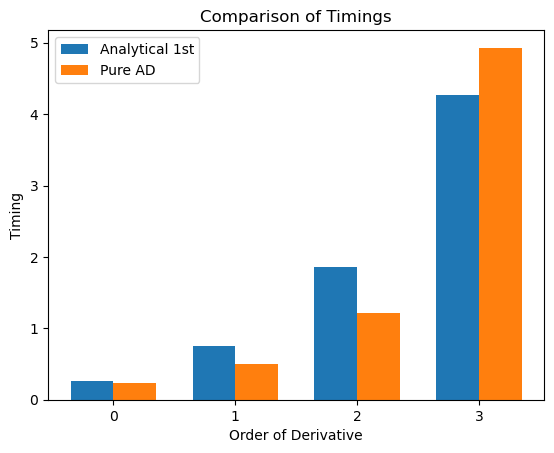

In [ ]:
n_values = list(t1.keys())
t1_timings = [t1[n] for n in n_values]
t2_timings = [t2[n] for n in n_values]

# Setting up the x-axis positions for the bars
bar_width = 0.35
index = np.arange(len(n_values))

# Plotting the bars
fig, ax = plt.subplots()
bar1 = ax.bar(index, t1_timings, bar_width, label='Analytical 1st')
bar2 = ax.bar(index + bar_width, t2_timings, bar_width, label='Pure AD')

# Adding labels and title
ax.set_xlabel('Order of Derivative')
ax.set_ylabel('Timing')
ax.set_title('Comparison of Timings')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(n_values)
ax.legend()

# Show the plot
plt.show()
